In [ ]:
from tiktoken import encoding_for_model
from src.model import GPT2, GPTConfig
import matplotlib.pyplot as plt
import numpy as np
import torch
import csv

In [7]:
DEVICE = "cpu"

In [8]:
checkpoint = torch.load("logs/model_20000.pt", map_location=torch.device("cpu"), weights_only=False)

In [9]:
model = GPT2(GPTConfig(vocab_size=50304, n_layer=12, n_head=12, n_embd=768))
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [10]:
enc = encoding_for_model("gpt2")
def generate_token_by_token(model, start, DEVICE, max_length=None):
    x = torch.tensor(enc.encode(start, allowed_special={'<|endoftext|>'}), dtype=torch.long).unsqueeze(0).repeat(1, 1).to(DEVICE)
    ix = torch.tensor([0])
    with torch.no_grad():
        tokens = []
        while ix.item() != enc.eot_token and (max_length is None or len(tokens) < max_length):
            logits, _ = model(x)
            logits = logits[:, -1, :]  # last token
            probs = torch.nn.functional.softmax(logits, dim=-1)
            topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
            ix = torch.multinomial(topk_probs, num_samples=1)
            xcol = torch.gather(topk_indices, -1, ix)
            x = torch.cat([x, xcol], dim=1)
            tokens.append(x[:, -1].item())
            yield enc.decode(tokens[-1:])  # yield the last token

In [75]:
start = input("Enter a prompt: ")
if not start:
    start = "<|endoftext|>"
else:
    print(start, end="")
for token in generate_token_by_token(model, start, DEVICE, max_length=100):
    print(token, end="")

"A child can start to develop an instinctive fear of getting things done," said Linda Williams of the University of Massachusetts, Amherst. "They can be easily stimulated to say things like "There's something that makes sure this child will do this," but the child needs a real sense of what might be going on in his or her body and mind."
Williams and her colleagues discovered in the first human trials that people with autism can't only tell whether to do something, but what the

In [11]:
sd = model.state_dict()

for k, v in sd.items():
    print(k, v.shape)

transformer.wte.weight torch.Size([50304, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.bias torch.Size([1, 1, 1024, 1024])
transformer.h.0.attn.c_attn.weight torch.Size([2304, 768])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.bias torch.Size([1, 1, 1024, 1024])
transformer.h.1.attn.c_attn.weight torch.Size([2304, 768])
transformer.h.1.attn.c_attn.b

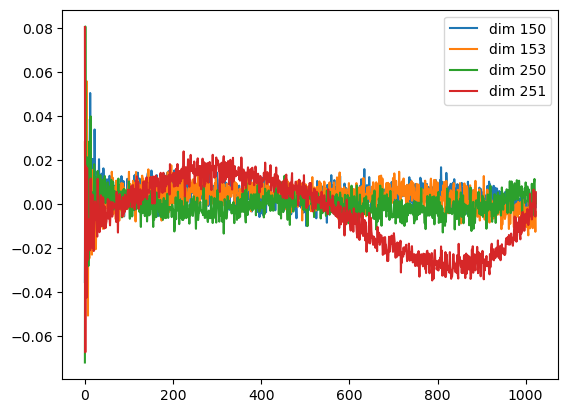

In [17]:
plt.plot(sd["transformer.wpe.weight"][:, 150].tolist(), label="dim 150")
plt.plot(sd["transformer.wpe.weight"][:, 153].tolist(), label="dim 153")
plt.plot(sd["transformer.wpe.weight"][:, 250].tolist(), label="dim 250")
plt.plot(sd["transformer.wpe.weight"][:, 251].tolist(), label="dim 251")
plt.legend()
plt.show()

In [70]:
with open("logs/log.csv") as f:
    logs = list(csv.DictReader(f))

steps = np.array([int(row["step"]) for row in logs])
tr = np.log10(np.array([float(row["train_loss"]) for row in logs]))
va = np.log10(np.array([float(row["val_loss"]) for row in logs]))
openaigpt2 = np.log10(3.2924)

valid = ~np.isnan(va)

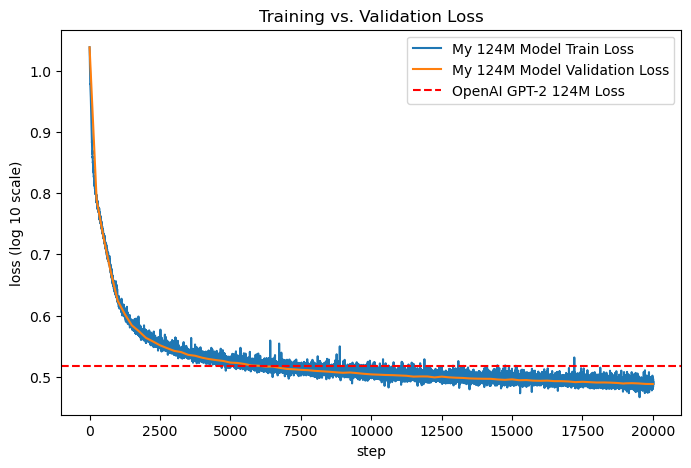

In [73]:
plt.figure(figsize=(8, 5))
plt.plot(steps, tr, label="My 124M Model Train Loss")
plt.plot(steps[valid], va[valid], label="My 124M Model Validation Loss")
plt.axhline(openaigpt2, color="red", linestyle="--", label="OpenAI GPT-2 124M Loss")
plt.xlabel("step")
plt.ylabel("loss (log 10 scale)")
plt.legend()
plt.title("Training vs. Validation Loss")
plt.show()